# Using aligned ELMo sentence embeddings for multilingual Offensive/Hateful speach classification

In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from elmoformanylangs import Embedder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
en_si_train, en_si_test = train_test_split(pd.concat([
    pd.read_csv("data/ours/en-si.tsv", sep="\t"),
    pd.read_csv("data/non-processed/dataset7/slv.txt", sep="\t", header=None, usecols=[0, 1], names=["EN", "SI"]),
]).dropna(), test_size=0.05)

en_si_train.head(30)

,EN,SI
632,ink,črnilo
1051,we protected them,mi smo jih zaščitili
22,Happy birthday!,Vse najboljše za rojstni dan
1392,open,odprto
933,Future,Prihodnjik
996,I can begin that,jaz lahko to začnem
2201,signal,signal
466,purple,vijolična
926,we spoke,smo govorili
1418,tend,nagibati se


In [3]:
class ELMoEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, path):
        self.elmo = Embedder(path)

    def fit(self, X, y = None):
        pass

    def transform(self, X, y = None):
        return np.stack([np.mean(e, axis=0) for e in self.elmo.sents2elmo([sentence.split(" ") for sentence in X], output_layer=0)])

## Load pretrained ELMo models
https://github.com/HIT-SCIR/ELMoForManyLangs

In [4]:
elmo_si_embedder = ELMoEmbedder("checkpoints/elmoformanylanguages/si")
elmo_en_embedder = ELMoEmbedder("checkpoints/elmoformanylanguages/en")

2021-05-20 17:44:46,796 WARNING: Could not find config.  Trying checkpoints/elmoformanylanguages/si/cnn_50_100_512_4096_sample.json
2021-05-20 17:44:46,797 WARNING: Could not find config.  Trying /home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/elmoformanylangs/configs/cnn_50_100_512_4096_sample.json
2021-05-20 17:44:46,807 INFO: char embedding size: 1991
2021-05-20 17:44:48,014 INFO: word embedding size: 257603
2021-05-20 17:44:54,152 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(257603, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(1991, 50, padding_idx=1988)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, ker

In [5]:
si_embeddings_train = elmo_si_embedder.transform(en_si_train["SI"].tolist())
en_embeddings_train = elmo_en_embedder.transform(en_si_train["EN"].tolist())

si_embeddings_test = elmo_si_embedder.transform(en_si_test["SI"].tolist())
en_embeddings_test = elmo_en_embedder.transform(en_si_test["EN"].tolist())

2021-05-20 17:45:00,792 INFO: 39 batches, avg len: 3.9
2021-05-20 17:45:01,453 INFO: Finished 1000 sentences.
2021-05-20 17:45:01,886 INFO: Finished 2000 sentences.
2021-05-20 17:45:02,454 INFO: 39 batches, avg len: 4.0
2021-05-20 17:45:02,811 INFO: Finished 1000 sentences.
2021-05-20 17:45:03,227 INFO: Finished 2000 sentences.
2021-05-20 17:45:03,519 INFO: 3 batches, avg len: 3.7
2021-05-20 17:45:03,638 INFO: 3 batches, avg len: 3.8


## Train embedding alignment model
LR model to align ELMo emebeddings & PCA to visuaize them

In [6]:
lr = LinearRegression()
lr.fit(si_embeddings_train, en_embeddings_train)

LinearRegression()

In [7]:
pca = PCA(n_components=2)
pca.fit(en_embeddings_train)

PCA(n_components=2)

## Evaluate embedding alignments

In [8]:
def plot_pca(pca, embeddings, verbs, top=10, label=None):
    embeddings_pca = pca.transform(embeddings)
    plt.scatter(embeddings_pca[:top,0], embeddings_pca[:top,1], label=label)
    for i, text in enumerate(verbs[:top]):
        plt.annotate(text, (embeddings_pca[i,0], embeddings_pca[i,1]))

def plot_alignment_errors(pca, e1, e2, top=10):
    e1_pca = pca.transform(e1)
    e2_pca = pca.transform(e2)
    for i in range(top):
        plt.plot([e1_pca[i,0], e2_pca[i,0]], [e1_pca[i,1], e2_pca[i,1]], linestyle="--", linewidth=1, alpha=0.5, color="gray", label="error" if i == 0 else None)

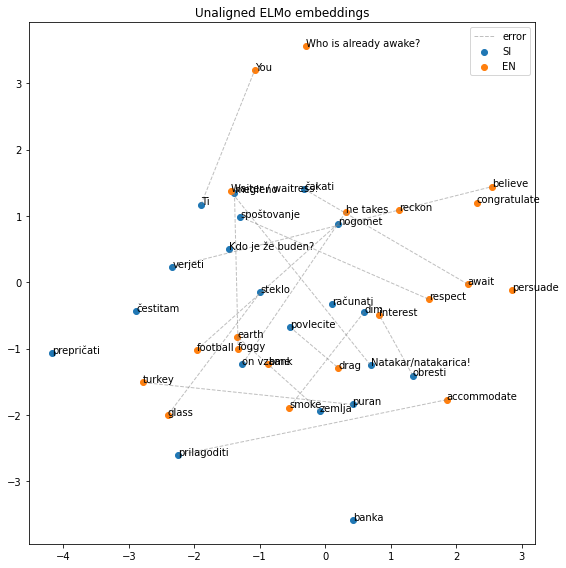

In [9]:
plt.figure(figsize=(8,8))
plot_pca(pca, si_embeddings_test, en_si_test["SI"].tolist(), top=20, label="SI")
plot_pca(pca, en_embeddings_test, en_si_test["EN"].tolist(), top=20, label="EN")
plot_alignment_errors(pca, si_embeddings_test, en_embeddings_test, top=15)
plt.title("Unaligned ELMo embeddings")
plt.legend()
plt.tight_layout()
plt.savefig("results/eval-elmo-alignment-unaligned-embeddings.pdf")

In [10]:
si_embeddings_test_aligned = lr.predict(si_embeddings_test)

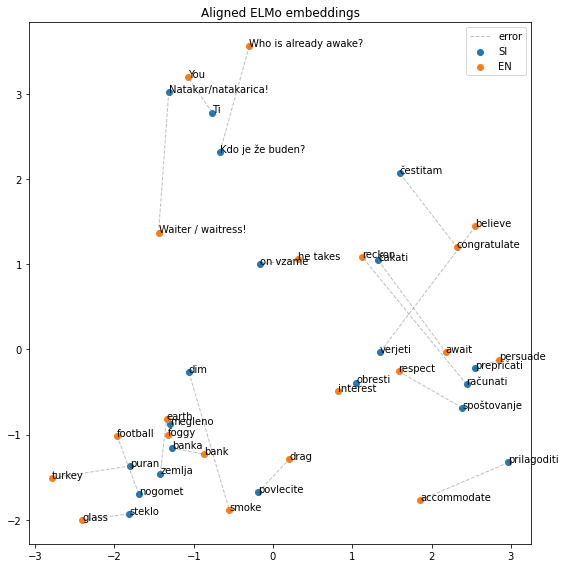

In [11]:
plt.figure(figsize=(8,8))
plot_pca(pca, si_embeddings_test_aligned, en_si_test["SI"].tolist(), top=20, label="SI")
plot_pca(pca, en_embeddings_test,         en_si_test["EN"].tolist(), top=20, label="EN")
plot_alignment_errors(pca, si_embeddings_test_aligned, en_embeddings_test, top=20)
plt.title("Aligned ELMo embeddings")
plt.legend()
plt.tight_layout()
plt.savefig("results/eval-elmo-alignment-aligned-embeddings.pdf")

## Train Offensive/Hateful speach classification model